In [1]:
import torch as th
import optuna

from environments.environment_tsp import EnviornmentTSP
from networks.basic_network import BasicNetwork
from networks.more_basic_net import MoreBasicNetwork
from params import default_params, set_tsp_params
from experiments.actor_critic_experiment import ActorCriticExperiment

# ------------------------- CONTROLLERS ----------------------------
from controllers.ac_controller import ActorCriticController
from controllers.epsilon_greedy_controller import EpsilonGreedyController
# ------------------------------------------------------------------

# ------------------------- LEARNERS --------------------------------
from learners.reinforce_learner import ReinforceLearner
from learners.biased_reinforce_learner import BiasedReinforceLearner
from learners.actor_critic_learner import ActorCriticLearner
from learners.off_policy_actor_critic_learner import OffpolicyActorCriticLearner
from learners.ppo_learner import PPOLearner
# ------------------------------------------------------------------

from generators.tsp_generator import TSPGenerator
from exact_solvers.solver_tsp import solve_tsp

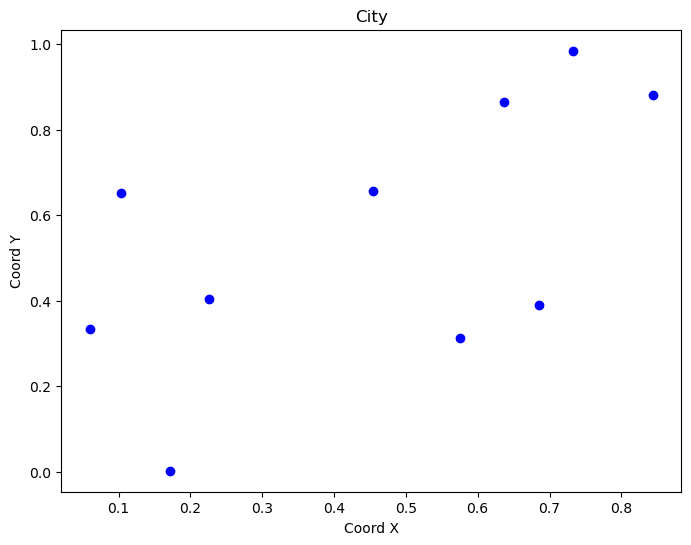

In [2]:
max_nodes_per_graph = 10
instance = 0
cities = th.load(f"training/tsp/size_{max_nodes_per_graph}/instance_{instance}.pt") 
tsp_generator = TSPGenerator()
tsp_generator.plot_instance(cities)

In [3]:
permutation, distance = solve_tsp(cities)
print(f"Permutation: {permutation}\nDistance: {distance}")

Permutation: [0, 5, 3, 8, 7, 4, 6, 9, 1, 2]
Distance: 2.9008774757385254


In [4]:
# Get params
params = default_params()

rollouts_per_batch = 50
pct_epsilon_anneal_time = 0.7
max_episodes = 500

params['problem'] = 'tsp'
params['node_dimension'] = 2
params['max_nodes_per_graph'] = max_nodes_per_graph
params['max_episode_length'] = max_nodes_per_graph + 1
params['max_episodes'] = max_episodes
params['batch_size'] = params['max_episode_length'] * rollouts_per_batch
params['max_steps'] = params['max_episodes'] * params['max_episode_length'] * rollouts_per_batch
params['epsilon_start'] = 1.0
params['epsilon_finish'] = 0.01
params['epsilon_anneal_time'] =  pct_epsilon_anneal_time * params['max_steps']
params['lr'] = 0.001
params['gamma'] = 0.99
params['entropy_regularization'] = True
params['entropy_weight'] = 1.0
params['plot_frequency'] = 10

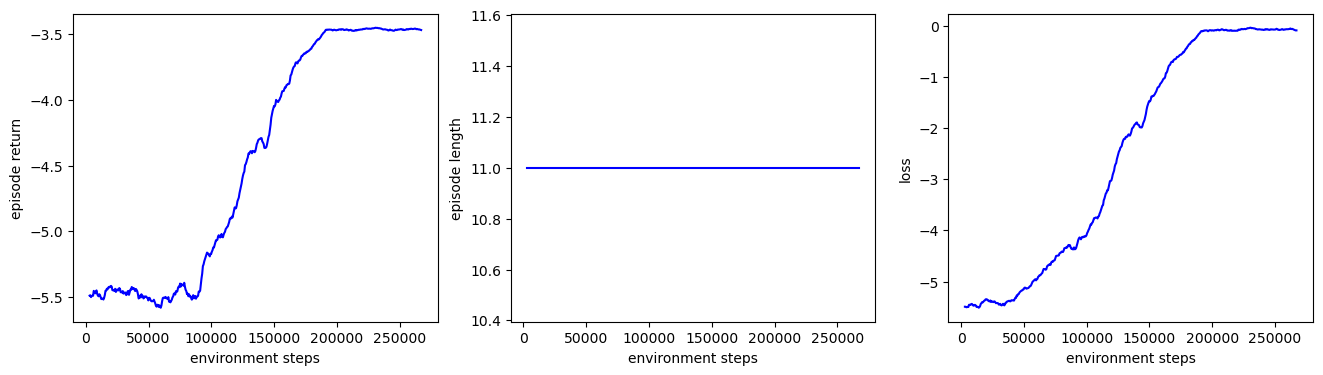

-3.462094

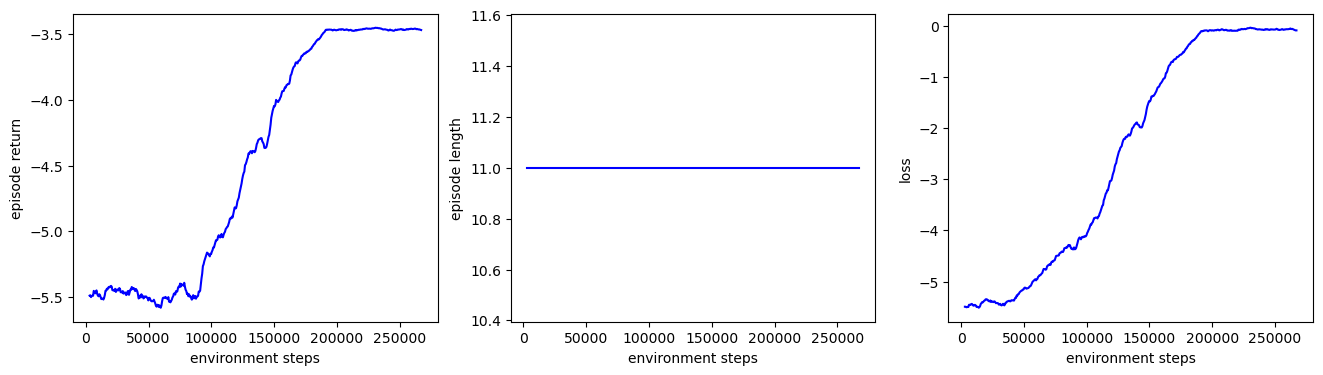

In [5]:
# Create network & env
model = MoreBasicNetwork(params)
env = EnviornmentTSP(cities = cities, max_nodes_per_graph = params['max_nodes_per_graph'], node_dimension = params['node_dimension'])

# Run experiment
experiment = ActorCriticExperiment(params, model, env, learner=ReinforceLearner(model, params=params))
experiment.run()

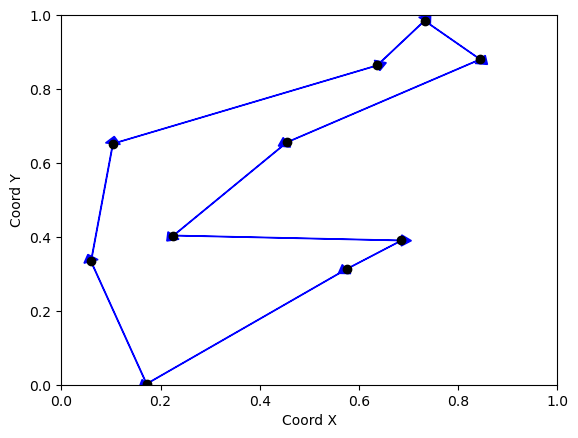

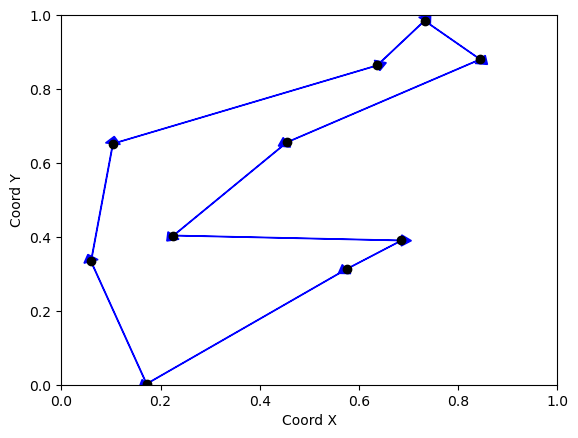

In [6]:
experiment.plot_rollout()

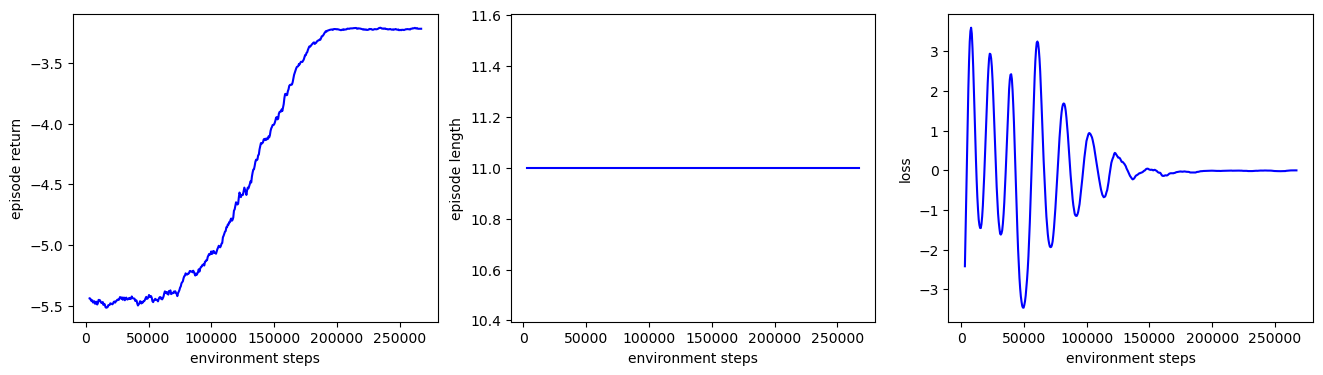

-3.2212362

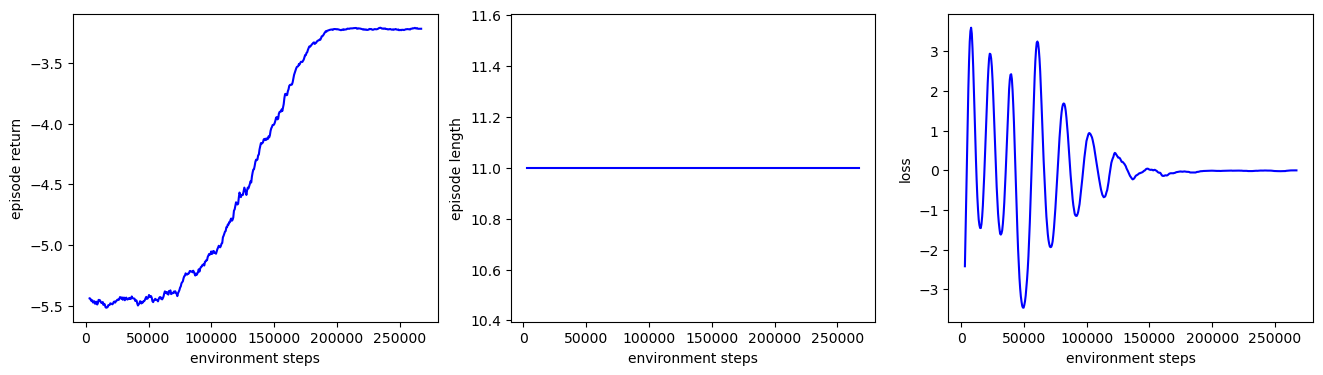

In [7]:
params['advantage_bias'] = True
params['value_targets'] = 'td'

# Create network
network = MoreBasicNetwork(params)

# Create environment
env = EnviornmentTSP(cities = cities, max_nodes_per_graph = params['max_nodes_per_graph'], node_dimension = params['node_dimension'])

# Create learner 
controller = ActorCriticController(network)
learner = BiasedReinforceLearner(model = network, controller = controller, params = params)

# Run experiment
experiment = ActorCriticExperiment(params = params, model = network, env = env, learner = learner)
experiment.run()

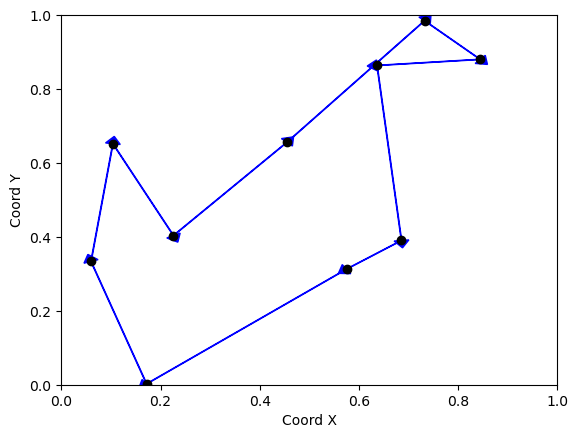

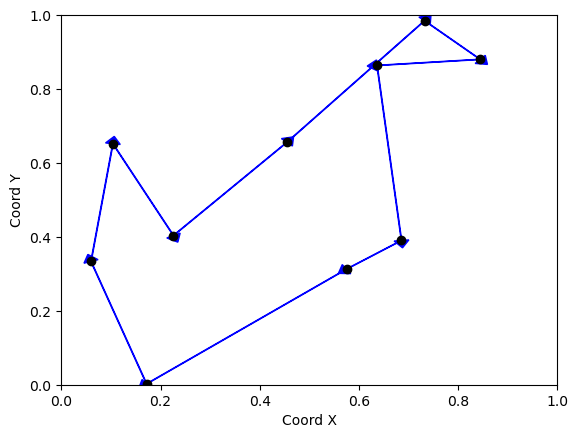

In [8]:
experiment.plot_rollout()

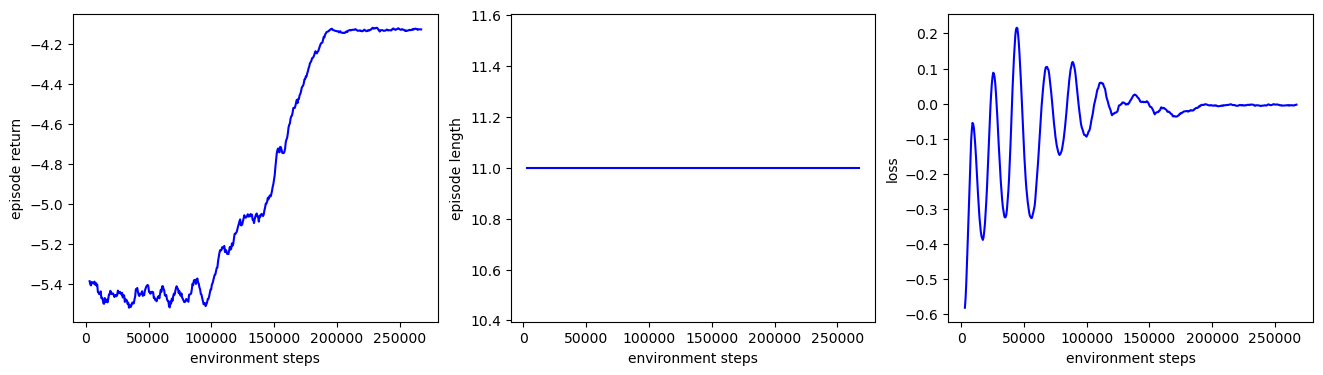

-4.1276803

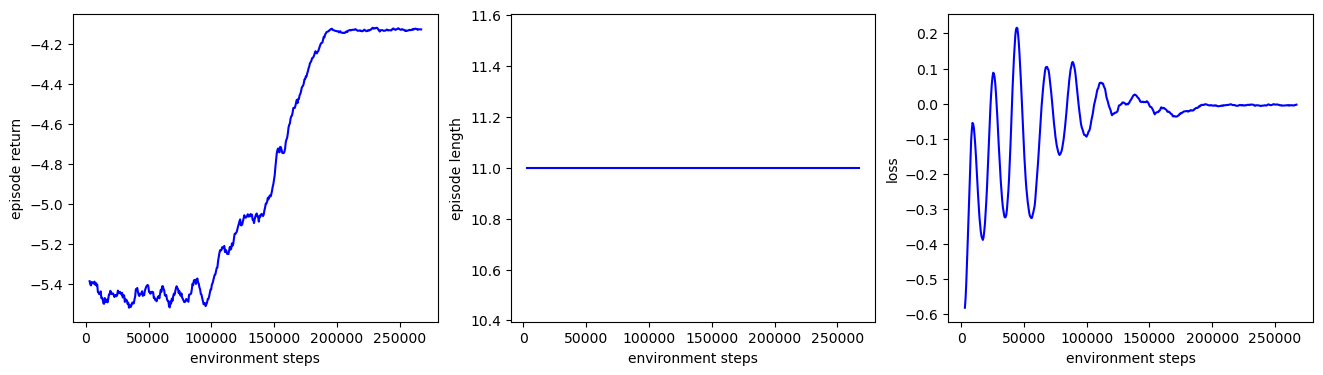

In [9]:
params['advantage_bootstrap'] = True

# Create network
network = MoreBasicNetwork(params)

# Create environment
env = EnviornmentTSP(cities = cities, max_nodes_per_graph = params['max_nodes_per_graph'], node_dimension = params['node_dimension'])

# Create learner 
controller = ActorCriticController(network)
learner = ActorCriticLearner(model = network, controller = controller, params = params)

# Run experiment
experiment = ActorCriticExperiment(params = params, model = network, env = env, learner = learner)
experiment.run()

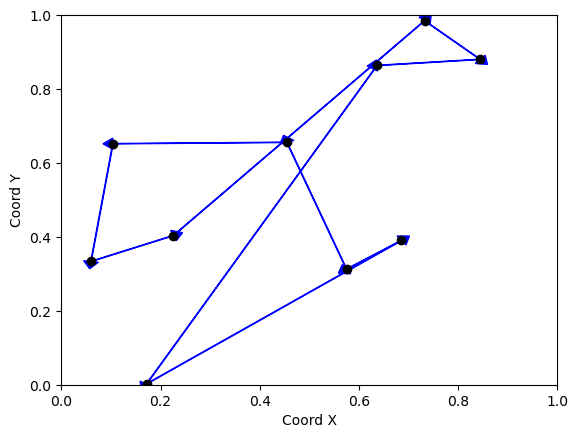

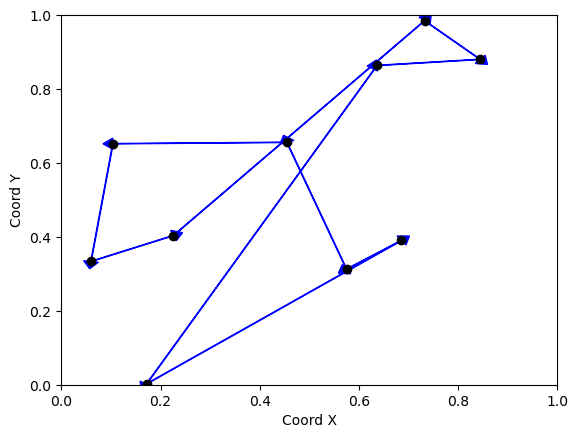

In [10]:
experiment.plot_rollout()

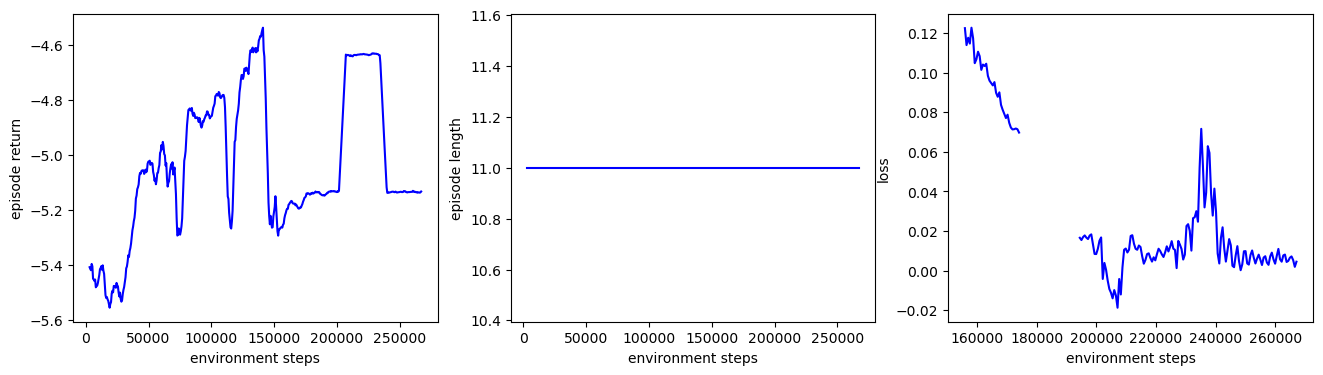

-4.9823103

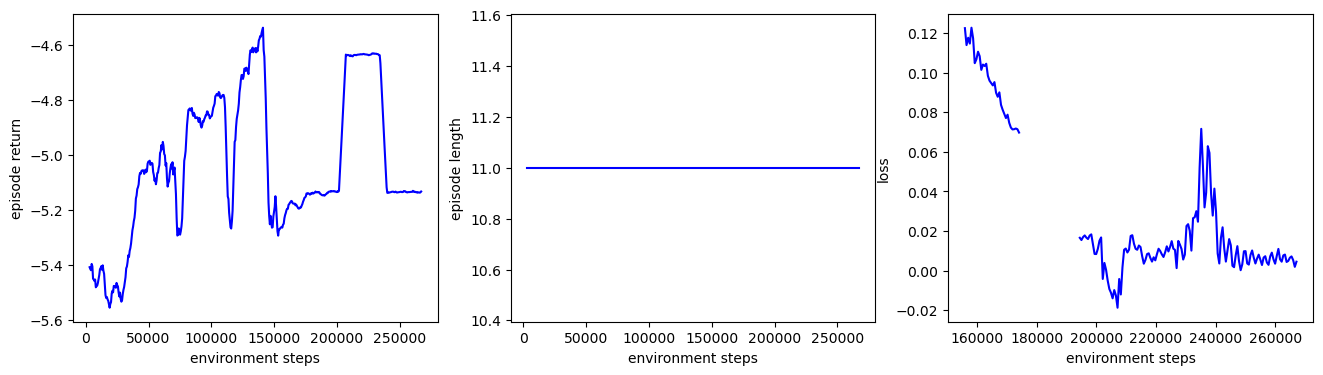

In [11]:
params['offpolicy_iterations'] = 10

# Create network
basic_network = MoreBasicNetwork(params)

# Create environment
env = EnviornmentTSP(cities = cities, max_nodes_per_graph = params['max_nodes_per_graph'], node_dimension = params['node_dimension'])

# Create learner 
controller = ActorCriticController(basic_network)
learner = OffpolicyActorCriticLearner(model = basic_network, controller = controller, params = params)

# Run experiment
experiment = ActorCriticExperiment(params = params, model = basic_network, env = env, learner = learner)
experiment.run()

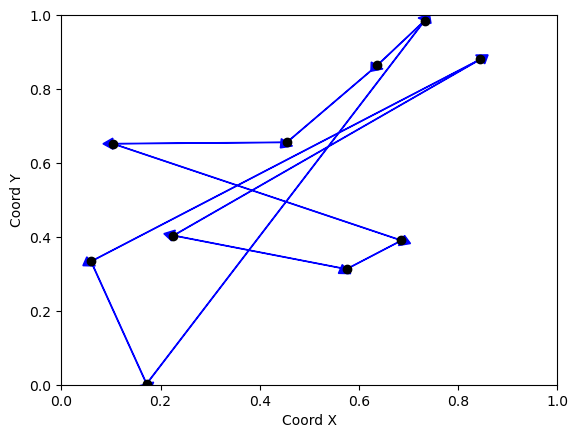

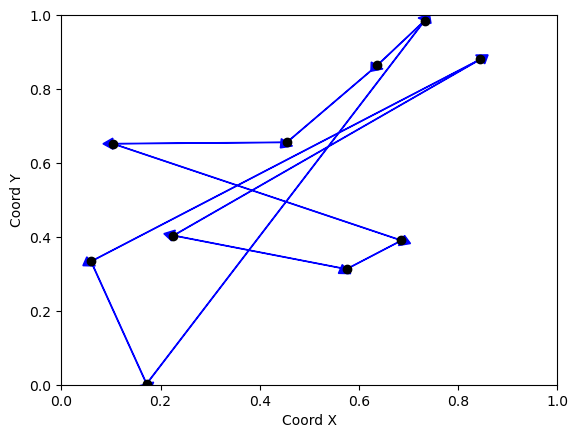

In [12]:
experiment.plot_rollout()

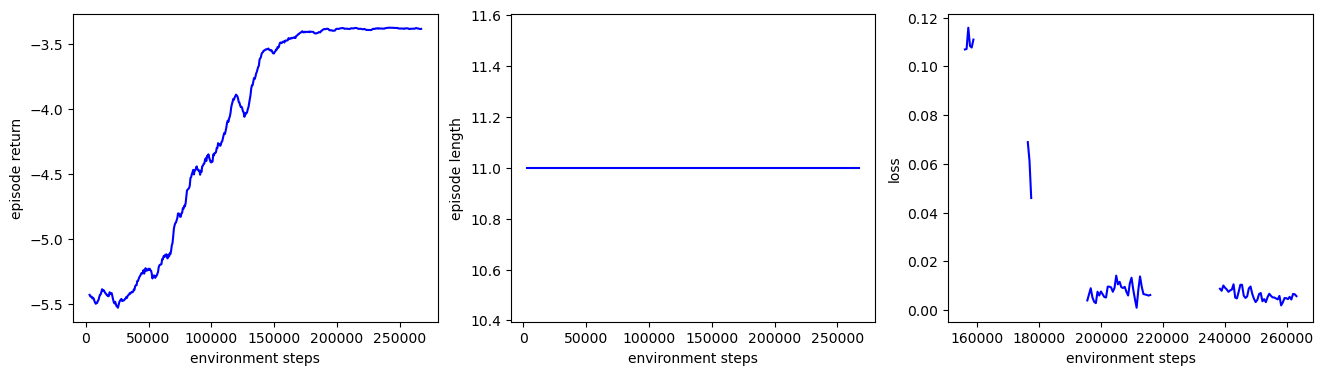

-3.3809998

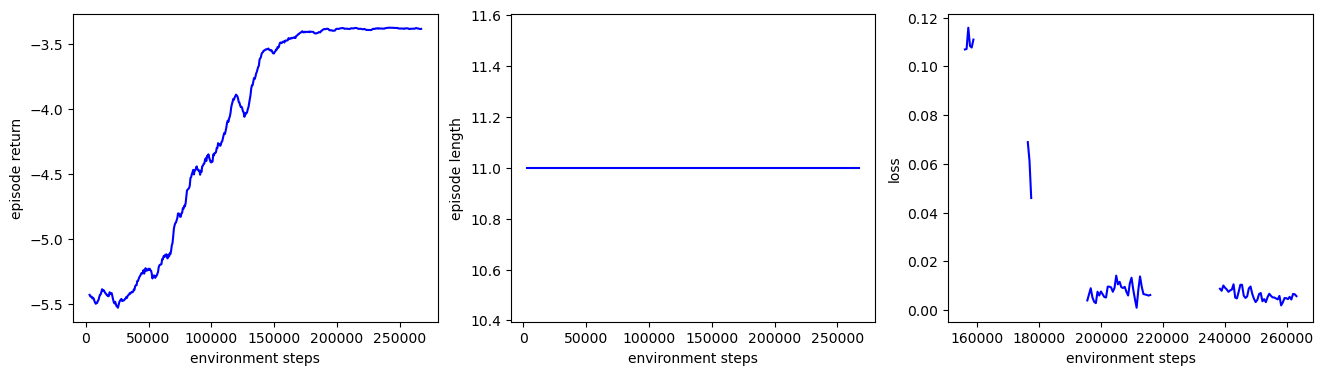

In [13]:
params['ppo_clipping'] = True
params['ppo_clip_eps'] = 0.1

# Create network
basic_network = MoreBasicNetwork(params)

# Create environment
env = EnviornmentTSP(cities = cities, max_nodes_per_graph = params['max_nodes_per_graph'], node_dimension = params['node_dimension'])

# Create learner 
controller = ActorCriticController(basic_network)
learner = PPOLearner(model = basic_network, controller = controller, params = params)

# Run experiment
experiment = ActorCriticExperiment(params = params, model = basic_network, env = env, learner = learner)
experiment.run()

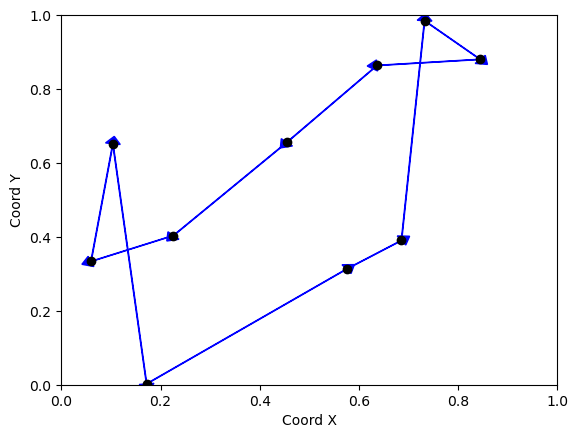

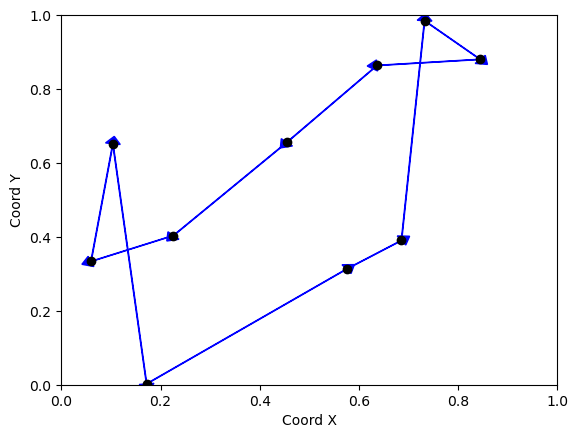

In [14]:
experiment.plot_rollout()

In [15]:
def objective(trial):
    # Define the hyperparameters as trial suggestions
    lr = trial.suggest_float('lr', 1e-6, 1e-1, log=True)
    pct_epsilon_anneal_time = trial.suggest_float('pct_epsilon_anneal_time', 0.3, 0.8)
    epsilon_start = trial.suggest_float('epsilon_start', 0.5, 1)
    epsilon_finish = trial.suggest_float('epsilon_finish', 0.00001, 0.5)

    # Use these parameters to create components
    params['epsilon_start'] = epsilon_start
    params['epsilon_finish'] = epsilon_finish
    params['epsilon_anneal_time'] = pct_epsilon_anneal_time * params['max_steps']
    params['lr'] = lr
    params['plot_frequency'] = None


    basic_network = MoreBasicNetwork(params)
    env = EnviornmentTSP(cities=cities, max_nodes_per_graph=params['max_nodes_per_graph'], 
                         node_dimension=params['node_dimension'])
    controller = ActorCriticController(basic_network)
    learner = ReinforceLearner(model=basic_network, controller=controller, params=params)
    experiment = ActorCriticExperiment(params=params, model=basic_network, env=env, learner=learner)

    # Perform training and return the evaluation metric
    final_metric = experiment.run()  # Assume `run` returns a performance indicator
    return final_metric

study = optuna.create_study(direction='maximize')  # or 'minimize' if you're minimizing a metric
study.optimize(objective, n_trials=25)  # You can adjust the number of trials

[I 2024-04-28 01:15:03,571] A new study created in memory with name: no-name-6e841655-f121-41ea-844f-6fe95eccb9e3
[W 2024-04-28 01:15:27,044] Trial 0 failed with parameters: {'lr': 0.020286453617511108, 'pct_epsilon_anneal_time': 0.7697770148118255, 'epsilon_start': 0.7912412183373272, 'epsilon_finish': 0.3227881304089683} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/tomas/miniconda3/envs/attention_tsp/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_35529/3743046434.py", line 24, in objective
    final_metric = experiment.run()  # Assume `run` returns a performance indicator
                   ^^^^^^^^^^^^^^^^
  File "/home/tomas/Desktop/TFG/code/experiments/actor_critic_experiment.py", line 65, in run
    batch = self.runner.run(self.batch_size, transition_buffer)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 